## Imports

In [841]:
import pygad
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import time
import pandas as pd
from functools import partial

## Creation of Datasets
We use the datasets of the companies in which we are going to invest and create 5 new datasets to run our program

In [848]:
companies = ['1', '2', '3']

### Daily Returns Dataset

In [852]:
daily_returns = pd.DataFrame()
for x in companies:
    company = pd.read_csv(f'company_{x}_january_2024.csv')
    daily_returns[f'Company_{x}_Daily_Return'] = company['daily_return']
    
daily_returns.to_csv('Daily_Returns_january_2024.csv', index=False)

daily_returns.head()

,Company_1_Daily_Return,Company_2_Daily_Return,Company_3_Daily_Return
0,0.013,0.030,0.020
1,0.019,0.012,0.012
2,-0.006,0.009,-0.005
3,0.024,0.010,0.013
4,0.013,0.019,0.018


### Daily Expected Returns Dataset

In [854]:
daily_exp_returns = pd.DataFrame()
for x in companies:
    company = pd.read_csv(f'company_{x}_january_2024.csv')
    daily_exp_returns[f'Company_{x}_Daily_Exp_Return'] = company['expected_return']
    
daily_exp_returns.to_csv('Expected_Daily_Returns_january_2024.csv', index=False)

daily_exp_returns.head()

,Company_1_Daily_Exp_Return,Company_2_Daily_Exp_Return,Company_3_Daily_Exp_Return
0,0.015,0.035,0.022
1,0.020,0.015,0.013
2,-0.007,0.011,-0.004
3,0.026,0.011,0.015
4,0.015,0.022,0.021


### Open Prices Dataset

In [856]:
open_prices = pd.DataFrame()
for x in companies:
    company = pd.read_csv(f'company_{x}_january_2024.csv')
    open_prices[f'Company_{x}_Open_Price'] = company['open_price']
    
open_prices.to_csv('Open_Prices_january_2024.csv', index=False)

open_prices.head()

,Company_1_Open_Price,Company_2_Open_Price,Company_3_Open_Price
0,150,85,230
1,152,88,235
2,155,89,238
3,154,90,237
4,158,91,240


### Close Prices Dataset

In [858]:
close_prices = pd.DataFrame()
for x in companies:
    company = pd.read_csv(f'company_{x}_january_2024.csv')
    close_prices[f'Company_{x}_Close_Price'] = company['close_price']
    
close_prices.to_csv('Close_Prices_january_2024.csv', index=False)

close_prices.head()

,Company_1_Close_Price,Company_2_Close_Price,Company_3_Close_Price
0,152,88,235
1,155,89,238
2,154,90,237
3,158,91,240
4,160,93,245


### Volatility Dataset

In [860]:
volatility = pd.DataFrame()
for x in companies:
    company = pd.read_csv(f'company_{x}_january_2024.csv')
    volatility[f'Company_{x}_Volatility'] = company['volatility']
    
volatility.to_csv('Volatility_january_2024.csv', index=False)

volatility.head()

,Company_1_Volatility,Company_2_Volatility,Company_3_Volatility
0,0.018,0.025,0.015
1,0.020,0.020,0.017
2,0.015,0.018,0.014
3,0.022,0.016,0.016
4,0.019,0.021,0.018


## Inicial values
The inicial value that we have to invest is 10000$, the number of companies in which we are going to invest is 3 and the daily risk-free rate for the stock market in January 2024 is aproximatelly 0.00959

In [935]:
current_value = 10000
n_comp = 3
risk_free_rate = 0.00959

## Financial Metrics

### Invested Money in a day

In [939]:
def invested(n_comp, actions, open_prices):
    sum = 0
    for i in range(n_comp):
        sum += actions[i]*open_prices[i]
    return sum      

### Investment Return in a day

In [942]:
def ret(n_comp, actions, close_prices, returns):
    sum = 0
    for i in range (n_comp):
        sum += close_prices[i]*(1+(returns[i]/100))*actions[i]
    return sum 

### Total Return
It measures the total return of an investment

In [945]:
def TR(ending_value, starting_value, dividends):
    return ((ending_value - starting_value)/starting_value)*100

### Return on Investment  
It measures the percentage return on an investment

In [948]:
def ROI(investment, earnings):
    return ((earnings - investment)/investment)*100

### Risk-Adjusted Return  
Performance of an investment given the Risk taken

In [951]:
def RAR (avg_return, risk_free_rate, avg_vol):
    return (avg_return-risk_free_rate)/avg_vol

## Genetic Model
We created a genetic model to that adjust the number os stocks that we buy for each company, based on the expected returns of each company for that day. If a return is expected to be negative, the weght is automatically 0, else it can be a value in the range of 0 to 10. If the value invested is negative or above budget the return of the fitness function is -infinite, so that the model does't develop those values

In [954]:
def fitness_func(ga_instance, solution, sol_idx):
    global daily_exp_returns, open_prices, current_value, day
    
    expected_return = daily_exp_returns.iloc[day].values
    prices = open_prices.iloc[day].values
    
    weights = np.array(solution, dtype=int)

    invested = 0
    gains = 0
    
    for i in range(n_comp):
        if (expected_return[i] < 0):
            weights[i] = 0
            
        invested += weights[i] * prices[i]
        gains += weights[i]*expected_return[i]
    
    if invested < 0 or invested > current_value:
        return -np.inf
    
    return gains

In [961]:
def daily_investment ():

    global n_comp, inicial_value, current_value, daily_returns, stock_prices
    
    def on_generation(ga_instance):
        print(f"Generation {ga_instance.generations_completed} complete") 
        print(f"Fitness of the best solution: {ga_instance.best_solution()[1]}")
        time.sleep(1)

    gene_space = [{'low': 0.00, 'high': 10.00} for _ in range(len(companies))]
    
    ga_instance = pygad.GA(
    num_generations=20, #Number of iterations of the genetic model
    num_parents_mating=5,
    fitness_func=fitness_func,
    sol_per_pop=10,
    num_genes=3, #Number of copanies to analyse
    gene_type=float,
    init_range_low=0, #Minimum number of stocks bought of a company
    init_range_high=10, #Maximum number of stocks bought of a company
    gene_space=gene_space,
    parent_selection_type="sss",
    keep_parents=2,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=100, #Percentage of the weights that can be altered at each iteraction
    on_generation=on_generation
    )

    fitness_function = partial(fitness_func, ga_instance=ga_instance)
    
    ga_instance.run()

    ga_instance.plot_fitness()

    print(f"Day: {day}")
    inicial_value = current_value
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    investment = invested(n_comp, solution, open_prices.iloc[day].values)
    returns = ret(n_comp, solution, close_prices.iloc[day], daily_returns.iloc[day].values)
    current_value += returns - investment
    total_returns = TR(current_value, inicial_value, 0)
    print(f"Inicial value: {inicial_value}")
    print(f"Current value: {current_value}")
    print(f"Actions Investment: {solution}")
    print(f"Invested Money: {investment:.2f}")
    print(f"Total Return: {total_returns:.2f}%")
    print(f"Return on Investment: {ROI(investment, returns):.2f}%")
    print(f"Risk-Adjusted Return: {RAR(total_returns, risk_free_rate, np.mean(volatility.iloc[day].values)):.2f}%")
    print()

## Investments
For the days in January that the market is open, we use the model and our preditions of the daily returns to invest in a stock when the market opens and sell it when the market closes. Then we measure several metrics to evaluate our investmentes (inicial value of the day, current value, money invested, total return, return on investment and risk-adjusted return

C:\Users\Utilizador\anaconda3\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 1 complete
Fitness of the best solution: 0.5609999999999999
Generation 2 complete
Fitness of the best solution: 0.5609999999999999
Generation 3 complete
Fitness of the best solution: 0.603
Generation 4 complete
Fitness of the best solution: 0.6260000000000001
Generation 5 complete
Fitness of the best solution: 0.648
Generation 6 complete
Fitness of the best solution: 0.648
Generation 7 complete
Fitness of the best solution: 0.648
Generation 8 complete
Fitness of the best solution: 0.648
Generation 9 complete
Fitness of the best solution: 0.648
Generation 10 complete
Fitness of the best solution: 0.648
Generation 11 complete
Fitness of the best solution: 0.648
Generation 12 complete
Fitness of the best solution: 0.648
Generation 13 complete
Fitness of the best solution: 0.648
Generation 14 complete
Fitness of the best solution: 0.648
Generation 15 complete
Fitness of the best solution: 0.648
Generation 16 complete
Fitness of the best solution: 0.648
Generation 17 complete
Fit

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


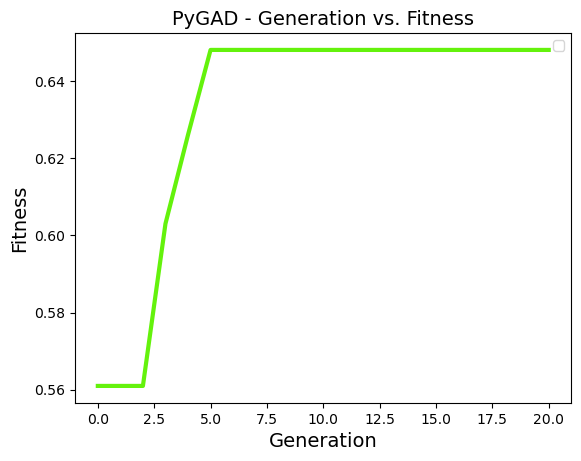

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_16132\685753541.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum += close_prices[i]*(1+(returns[i]/100))*actions[i]


Day: 0
Inicial value: 10000
Current value: 10097.534249274435
Actions Investment: [9.05291136 9.65554006 9.91242611]
Invested Money: 4458.52
Total Return: 0.98%
Return on Investment: 2.19%
Risk-Adjusted Return: 49.95%

Generation 1 complete
Fitness of the best solution: 0.391
Generation 2 complete
Fitness of the best solution: 0.40399999999999997
Generation 3 complete
Fitness of the best solution: 0.419
Generation 4 complete
Fitness of the best solution: 0.419
Generation 5 complete
Fitness of the best solution: 0.419
Generation 6 complete
Fitness of the best solution: 0.419
Generation 7 complete
Fitness of the best solution: 0.432
Generation 8 complete
Fitness of the best solution: 0.432
Generation 9 complete
Fitness of the best solution: 0.432
Generation 10 complete
Fitness of the best solution: 0.432
Generation 11 complete
Fitness of the best solution: 0.432
Generation 12 complete
Fitness of the best solution: 0.432
Generation 13 complete
Fitness of the best solution: 0.432
Generatio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


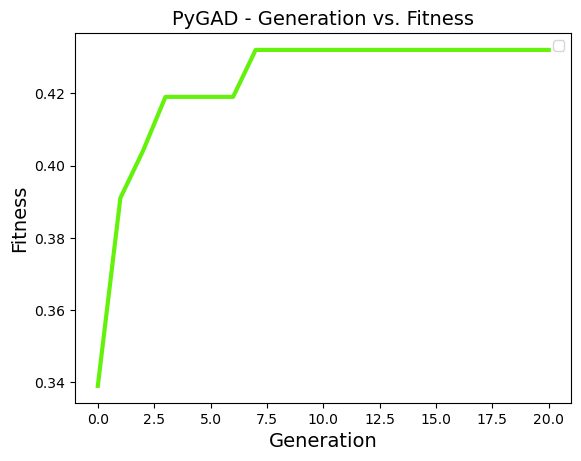

Day: 1
Inicial value: 10097.534249274435
Current value: 10164.963476613113
Actions Investment: [9.77176073 9.08120743 9.45927176]
Invested Money: 4507.38
Total Return: 0.67%
Return on Investment: 1.50%
Risk-Adjusted Return: 34.64%

Generation 1 complete
Fitness of the best solution: 0.09899999999999999
Generation 2 complete
Fitness of the best solution: 0.09899999999999999
Generation 3 complete
Fitness of the best solution: 0.09899999999999999
Generation 4 complete
Fitness of the best solution: 0.09899999999999999
Generation 5 complete
Fitness of the best solution: 0.09899999999999999
Generation 6 complete
Fitness of the best solution: 0.09899999999999999
Generation 7 complete
Fitness of the best solution: 0.09899999999999999
Generation 8 complete
Fitness of the best solution: 0.09899999999999999
Generation 9 complete
Fitness of the best solution: 0.09899999999999999
Generation 10 complete
Fitness of the best solution: 0.09899999999999999
Generation 11 complete
Fitness of the best solu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


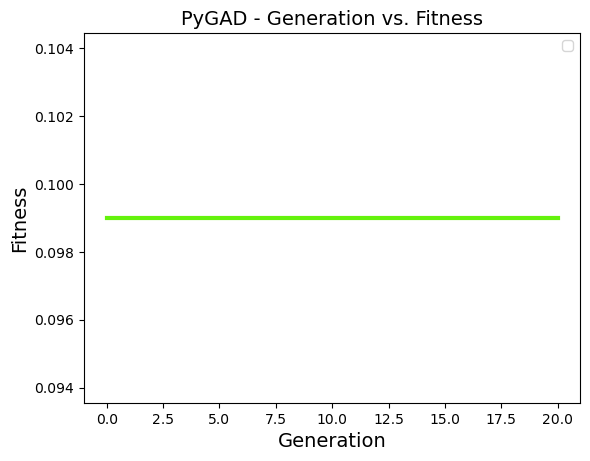

Day: 2
Inicial value: 10164.963476613113
Current value: 10172.97968935157
Actions Investment: [0.46269007 9.20208265 0.78414928]
Invested Money: 1077.33
Total Return: 0.08%
Return on Investment: 0.74%
Risk-Adjusted Return: 4.42%

Generation 1 complete
Fitness of the best solution: 0.40099999999999997
Generation 2 complete
Fitness of the best solution: 0.42299999999999993
Generation 3 complete
Fitness of the best solution: 0.43799999999999994
Generation 4 complete
Fitness of the best solution: 0.43799999999999994
Generation 5 complete
Fitness of the best solution: 0.45299999999999996
Generation 6 complete
Fitness of the best solution: 0.45299999999999996
Generation 7 complete
Fitness of the best solution: 0.45299999999999996
Generation 8 complete
Fitness of the best solution: 0.45699999999999996
Generation 9 complete
Fitness of the best solution: 0.46799999999999997
Generation 10 complete
Fitness of the best solution: 0.46799999999999997
Generation 11 complete
Fitness of the best soluti

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


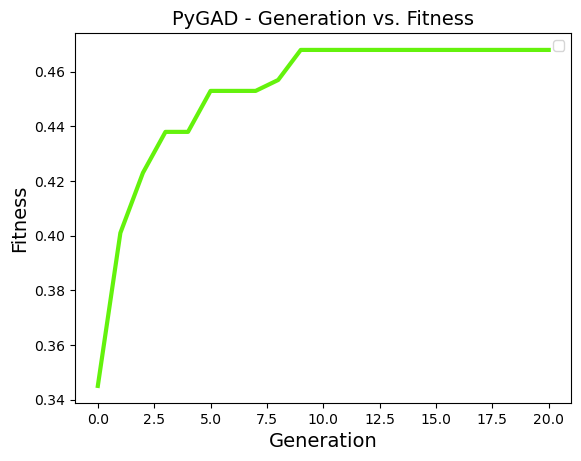

Day: 3
Inicial value: 10172.97968935157
Current value: 10251.25696332573
Actions Investment: [9.48916665 9.75744322 9.93485822]
Invested Money: 4694.06
Total Return: 0.77%
Return on Investment: 1.67%
Risk-Adjusted Return: 42.22%

Generation 1 complete
Fitness of the best solution: 0.479
Generation 2 complete
Fitness of the best solution: 0.486
Generation 3 complete
Fitness of the best solution: 0.486
Generation 4 complete
Fitness of the best solution: 0.492
Generation 5 complete
Fitness of the best solution: 0.5069999999999999
Generation 6 complete
Fitness of the best solution: 0.5069999999999999
Generation 7 complete
Fitness of the best solution: 0.5069999999999999
Generation 8 complete
Fitness of the best solution: 0.5069999999999999
Generation 9 complete
Fitness of the best solution: 0.5069999999999999
Generation 10 complete
Fitness of the best solution: 0.5069999999999999
Generation 11 complete
Fitness of the best solution: 0.522
Generation 12 complete
Fitness of the best solution:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


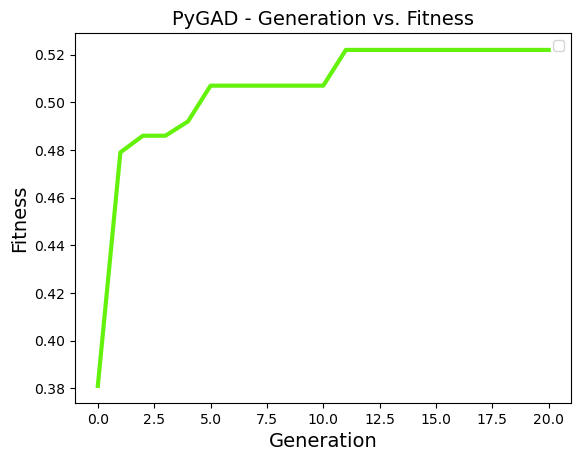

Day: 4
Inicial value: 10251.25696332573
Current value: 10339.833219507886
Actions Investment: [9.47680152 9.54749988 9.94465447]
Invested Money: 4752.87
Total Return: 0.86%
Return on Investment: 1.86%
Risk-Adjusted Return: 44.20%

Generation 1 complete
Fitness of the best solution: 0.251
Generation 2 complete
Fitness of the best solution: 0.258
Generation 3 complete
Fitness of the best solution: 0.271
Generation 4 complete
Fitness of the best solution: 0.271
Generation 5 complete
Fitness of the best solution: 0.271
Generation 6 complete
Fitness of the best solution: 0.284
Generation 7 complete
Fitness of the best solution: 0.284
Generation 8 complete
Fitness of the best solution: 0.297
Generation 9 complete
Fitness of the best solution: 0.297
Generation 10 complete
Fitness of the best solution: 0.297
Generation 11 complete
Fitness of the best solution: 0.297
Generation 12 complete
Fitness of the best solution: 0.297
Generation 13 complete
Fitness of the best solution: 0.297
Generation 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


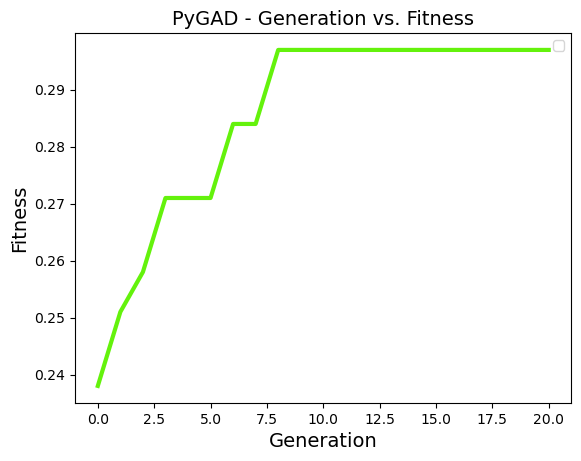

Day: 5
Inicial value: 10339.833219507886
Current value: 10405.533985062357
Actions Investment: [9.9340459  3.15649629 9.67573673]
Invested Money: 4253.56
Total Return: 0.64%
Return on Investment: 1.54%
Risk-Adjusted Return: 34.77%

Generation 1 complete
Fitness of the best solution: 0.19799999999999998
Generation 2 complete
Fitness of the best solution: 0.19799999999999998
Generation 3 complete
Fitness of the best solution: 0.19799999999999998
Generation 4 complete
Fitness of the best solution: 0.19799999999999998
Generation 5 complete
Fitness of the best solution: 0.19799999999999998
Generation 6 complete
Fitness of the best solution: 0.19799999999999998
Generation 7 complete
Fitness of the best solution: 0.19799999999999998
Generation 8 complete
Fitness of the best solution: 0.19799999999999998
Generation 9 complete
Fitness of the best solution: 0.19799999999999998
Generation 10 complete
Fitness of the best solution: 0.19799999999999998
Generation 11 complete
Fitness of the best solu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


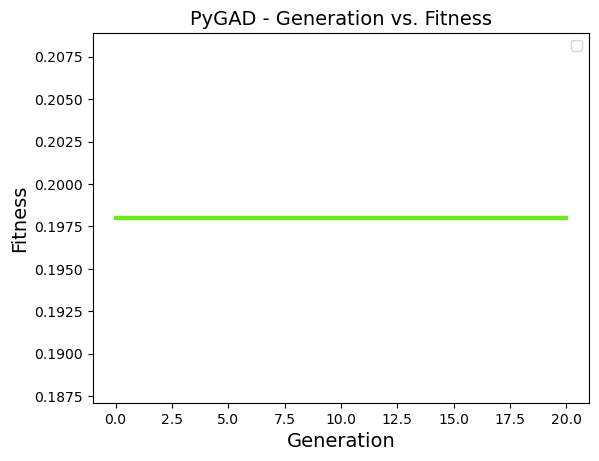

Day: 6
Inicial value: 10405.533985062357
Current value: 10407.204955476609
Actions Investment: [7.49488371 9.18452979 4.62337251]
Invested Money: 3214.99
Total Return: 0.02%
Return on Investment: 0.05%
Risk-Adjusted Return: 0.35%



In [958]:
for i in range (7):
    day = i
    daily_investment()

Referências:  
https://www.digitalocean.com/community/tutorials/genetic-algorithm-applications-using-pygad  